In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Workflow

1. Prepare and load data
2. Build model
3. Fit the model (training)
4. Making predicitions and evaluating the model (inference)
5. Saving and loading the model

### 1. Prepare and load the data

In [2]:
# Known parameters for simple linear regression model
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X), len(y)

(50, 50)

#### Splitting into training and test set

In [4]:
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

#### Visualize data

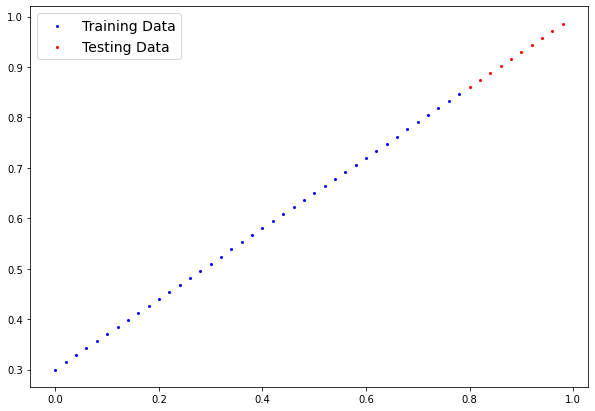

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test,
                     predictions=None):
    
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")

    plt.scatter(test_data, test_labels, c="r", s=4, label="Testing Data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="g", s=4, label="Predictions")

    plt.legend(prop={"size":14})
    plt.show()

plot_predictions()

### 2. Build Model

This model with start with random values for weight and bias then look at training data and adjust to get the ideal values

This model will use gradient descent and backpropagation

In [6]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

### Model Building Essentials

* torch.nn - contains all the of the buildingss for computational graphs
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require youo to overwrite forward(), this method defines what happens in the forward computation

### Checking contents of our PyTorch model

In [7]:
torch.manual_seed(42)
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [9]:
weight, bias

(0.7, 0.3)

The goal is to start with random values and get them as close to ideal values (as seen above)

But in real life, you'll never know the true ideal values

### Predictions

In [10]:
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [11]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

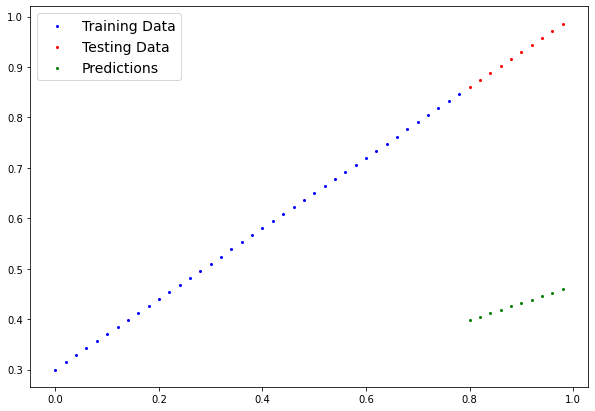

In [12]:
plot_predictions(predictions=y_preds)

### 3. Training & 4. Testing

In [13]:
# Loss function
loss_fn = nn.L1Loss()

# Optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                             lr=0.01) # learning rate

#### Training and testing loop

1. Loop through data
2. Forward pass
3. Calculate the loss
4. Optimizer zero grad
5. Loss backward
6. Optimizer step

In [14]:
# An epoch is one loop through the data
epochs = 500

# Tracking 
epoch_count = []
loss_values = []
test_loss_values = []

### TRAINING
# 1. Loop through data
for epoch in range(epochs):
    # Set model to training mode
    model_0.train()

    # 2. Forward pass
    y_pred = model_0(X_train)

    # 3. Calculate the loss (MAE - mean absolute error)
    loss = loss_fn(y_pred, y_train)

    # 4. Optimizer zero grad
    optimizer.zero_grad()

    # 5. Loss backward/back propigation
    loss.backward()

    # 6. Optimizer step
    optimizer.step()

    ### TESTING
    # Turn off settings in model that are not required in eval/testing
    model_0.eval()

    # Turn off gradient tracking + more
    with torch.inference_mode():
        # 2. Forward pass
        test_pred = model_0(X_test)

        # 3. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(model_0.state_dict())


OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
OrderedDict([('weights', tensor([0.5800])), ('bias', tensor([0.3503]))])
OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])
OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])
OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])


In [15]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

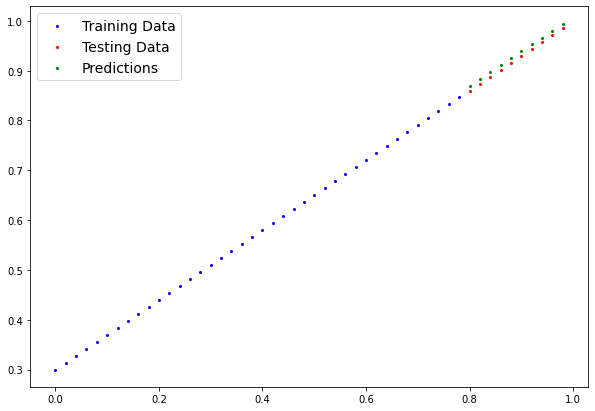

In [16]:
plot_predictions(predictions=y_preds_new)

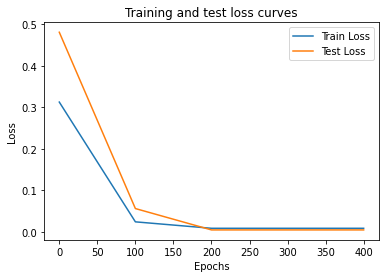

In [17]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test Loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

### Saving a model in PyTorch

1. `torch.save()` - save PyTorch model in pickle
2. `torch.load()` - load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - load a model's saved state dictionary

In [18]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [21]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = 'workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save model state_dict
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

### Loading Model

Since we only saved the state_dict we need to create a new model instance and load the state_dict into that

In [22]:
# New model class instance
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [24]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])